# tutorial 2: screen inputs

This tutorial show you how to build and visualize multichannel pipelines with pipecaster, and how to use classes from the **channel_selection** module to screen features matrices during pipeline fitting.  Feature matrix screening can prevent garbage from flowing into and out of your ML pipeline.

Additional libraries required to execute this notebook:  
* matplotlib  
* scipy

## Channel Selection

In ML tasks with a large number of potentially useful feature matrix inputs originating from different data sources or from different feature extraction methods, it can be useful to select informative matrices prior to the ML stage of the pipeline.  Although ML algorithms are good at ignoring input noise, their capacity to do so is finite.  Thus, reducing input noise by selecting high quality input matrices can sometimes improve performance by reducing overfitting.  Matrix selection can also dramatically reduce the computational cost of model training and inference.  

Pipecaster's **channel_selection** module provides the **ChannelSelector** class and a set of derived classes that enable in-pipeline screening of input matrices. 

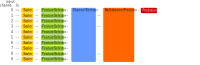

In [5]:
from IPython.display import SVG, display
display(SVG('fig_2_1.svg'))



The pipeline illustrated in the previous cell takes 10 different input feature matrices (with identical

This example builds on example 1.1 by adding scaling, feature selection, and channel selection layers at the beginning of the pipeline.  ML models often perform better if low quality and non-informative features are filtered out using feature selection methods.  Filtering out low quality features improves performance when the cost of overfitting the noise in these features outweighs the benefit of their informative signal.  

**scaling and feature selection**  
The scaler and feauture selector algorithms used in the example below, StandardScaler() and SelectPercentile(), are scikit-learn estimator/transformers that are broadcast across all inputs.  

**channel selection**  
The channel selector used in this example, **SelectKBestScores**, computes a univariate feature score for each feature of a matrix then aggregates the score into a single value using an aggregator function (in this example np.mean).  The top k scoring channels are then selected for output (k=3 in this example).
    Related classes: **SelectPercentBestScores**, **SelectHighPassScores**, **SelectVarianceHighPassScores**.

In [7]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC 
import pipecaster as pc

early_stopping_GBC = GradientBoostingClassifier(n_estimators=1000, 
                                     validation_fraction=0.1, 
                                     n_iter_no_change=3)
mclf1 = pc.MultichannelPipeline(n_channels=n_inputs)
mclf1.add_layer(StandardScaler())
mclf1.add_layer(SelectPercentile(percentile=25))
mclf1.add_layer(pc.SelectKBestScores(feature_scorer=f_classif, aggregator=np.mean, k=3))
mclf1.add_layer(early_stopping_GBC)
mclf1.add_layer(pc.MultichannelPredictor(SVC()))
mclf1

MultichannelPipeline(internal_cv=5, cv_processes=1, transform_method_name=None, n_channels=10)

In [8]:
df = mclf1.fit(Xs, y).get_dataframe()
df['input_type'] = X_types
df

layer_0 out_0           layer_1 out_1            layer_2  \
channel                                                                    
0        StandardScaler     →  SelectPercentile     →  SelectKBestScores   
1        StandardScaler     →  SelectPercentile     →                  ▽   
2        StandardScaler     →  SelectPercentile     →                  ▽   
3        StandardScaler     →  SelectPercentile     →                  ▽   
4        StandardScaler     →  SelectPercentile     →                  ▽   
5        StandardScaler     →  SelectPercentile     →                  ▽   
6        StandardScaler     →  SelectPercentile     →                  ▽   
7        StandardScaler     →  SelectPercentile     →                  ▽   
8        StandardScaler     →  SelectPercentile     →                  ▽   
9        StandardScaler     →  SelectPercentile     →                  ▽   

        out_2                           layer_3 out_3     layer_4 out_4  \
channel                                                                   
0                                                      {SVC_MC}tr     →   
1                                                               ▽         
2           →  {GradientBoostingClassifier}cvtr     →           ▽         
3                                                               ▽         
4                                                               ▽         
5                                                               ▽         
6                                                               ▽         
7           →  {GradientBoostingClassifier}cvtr     →           ▽         
8                                                               ▽         
9           →  {GradientBoostingClassifier}cvtr     →           ▽         

          input_type  
channel               
0             random  
1             random  
2        informative  
3             random  
4             random  
5             random  
6             random  
7        informative  
8             random  
9        informative

**Notes on dataframe visualization**: 
* The type of input matrix appears in the input_type column on the right.
* The informative inputs, shown in input_type column, should exactly match the output arrows in the out_2 column if channel selection was perfect.
* The output arrow for layer 2 show the real channel selection that occured during pipeline fitting.
* In layer 3, GradientBoostingClassifier is surrounded by brackets and followed by "cvtr".  This notation indicates that the predictor has been automatically wrapped in a class to provide internal cross validation training and transform functionality.  Internal cv training is used to prevent base predictors from making inferences on their own training data when training a meta-predictor.

### Performance analysis

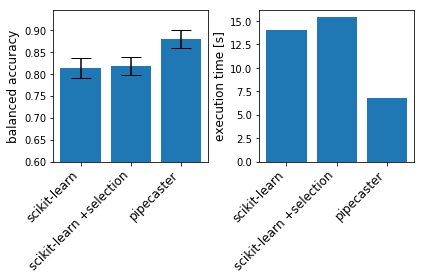

In [9]:
%matplotlib inline
import time
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectPercentile
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from scipy.stats import sem

n_cpus = pc.count_cpus()

t = time.time()
pc_accuracies = pc.cross_val_score(mclf1, Xs, y, scorer=balanced_accuracy_score, cv=10, n_processes=n_cpus)
pc_time = time.time() - t

X = np.concatenate(Xs, axis=1)
clf = Pipeline([('scaler', StandardScaler()), 
                ('selector', SelectPercentile(score_func=f_classif, percentile=100)),
                ('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_time = time.time() - t

clf = Pipeline([('GradientBoostingClassifier', early_stopping_GBC)])
t = time.time()
sk_ns_accuracies = cross_val_score(clf, X, y, scoring='balanced_accuracy', cv=10, n_jobs=n_cpus)
sk_ns_time = time.time() - t

fig, axes = plt.subplots(1, 2)
xlabels = ['scikit-learn', 'scikit-learn +selection', 'pipecaster']
axes[0].bar(xlabels, [np.mean(sk_ns_accuracies), np.mean(sk_accuracies), np.mean(pc_accuracies)], 
        yerr=[sem(sk_ns_accuracies), sem(sk_accuracies), sem(pc_accuracies)], capsize=10)
axes[0].set_ylim(.6)
axes[0].set_ylabel('balanced accuracy', fontsize=12)
axes[0].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
axes[1].bar(xlabels, [np.mean(sk_ns_time), np.mean(sk_time), np.mean(pc_time)])
axes[1].set_ylabel('execution time [s]', fontsize=12)
axes[1].set_xticklabels(xlabels, rotation=45, ha='right', fontsize=12)
plt.tight_layout()

**Results**  
The pipecaster pipeline performs better on this task than pipeline architectures that take concatenated features (scikit-learn, and scikit-learn + feature selection).